<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/simulation/HyperbolicPDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 双極型: 波動方程式

波動方程式
\begin{equation}
    \frac{∂^2u}{∂t^2}=c^2\frac{∂^2u}{∂x^2}
\end{equation}
を解く。条件は
- $c=1$
- $x\in[0,1]$,
- $t\in[0,0.4]$,
- $u(0,t)=u(1,t)=0$ (境界条件).

ただし数値不安定性を避けるために、
時間方向の刻み幅$k$は空間方向の刻み幅$h$に対して
\begin{equation}
    k\leq\frac{h}{c}
\end{equation}
を満たすように選ぶ (CFL 条件)。

In [2]:
import numpy as np

speed = 1

x_diff = 0.01
x_list = np.arange(0, 1, x_diff)

t_diff = x_diff / speed
t_list = np.arange(0, 0.4, t_diff)

初期条件は
\begin{equation}
    u(x,0)=
    \begin{cases}
        &\dfrac{1}{2}\cos(8\pi(x-1/2))+\dfrac{1}{2}\quad(3/8\leq x\leq5/8), \\
        &0\quad(\text{otherwise}),
    \end{cases}
\end{equation}
および
\begin{equation}
    \frac{∂u}{∂t}(x,0)=0
\end{equation}
とする.

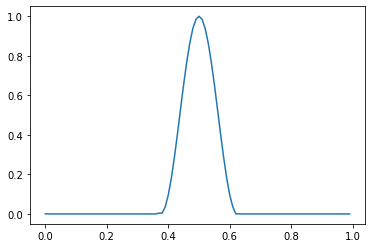

In [5]:
import matplotlib.pyplot as plt

u_start = 0.5 * np.cos(8 * np.pi * (x_list - 0.5)) + 0.5
u_start[0:int(3/8/x_diff)] = u_start[int(5/8/x_diff):] = 0

plt.plot(x_list, u_start)
plt.show()

数値積分は連立1次方程式の形
\begin{align}
    &\frac{∂u}{∂t}(x,t)≡v(x,t), \\
    &\frac{∂v}{∂t}=c^2\frac{∂^2u}{∂x^2}
\end{align}
で解く.係数行列は
\begin{equation}
    \begin{pmatrix}
        ∂_tu \\ ∂_tv
    \end{pmatrix}
    =
    \begin{pmatrix}
        O & I \\ c^2∂_x^2 & O
    \end{pmatrix}
    \begin{pmatrix}
        u \\ v
    \end{pmatrix}
\end{equation}
の差分化である。


In [7]:
from scipy import sparse

u_1 = sparse.lil_matrix(sparse.eye(len(x_list), k=-1))
u_1[0, :] = 0
u_1 = sparse.csr_matrix(u_1)

id_mat = sparse.identity(len(x_list))

u1 = sparse.lil_matrix(sparse.eye(len(x_list), k=1))
u1[-1, :] = 0
u1 = sparse.csr_matrix(u1)

diff_mat = (u1 -2 * id_mat + u_1) / (x_diff ** 2)

zero_mat = sparse.csr_matrix((len(x_list), len(x_list)))

coeff_mat = sparse.bmat([[zero_mat, id_mat], [diff_mat, zero_mat]])

def diff_operator(t, u_list):
    return coeff_mat * u_list

In [12]:
from scipy.integrate import solve_ivp

u_sol = solve_ivp(diff_operator, t_span=(0, 0.4), 
                  y0=np.hstack([u_start, np.zeros(len(x_list))]), 
                  method="RK45", dense_output=True, rtol=1e-8)
u_list = u_sol.sol(t_list).T[:, 0:len(x_list)]

In [10]:
%%capture
!pip install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.animation as animation

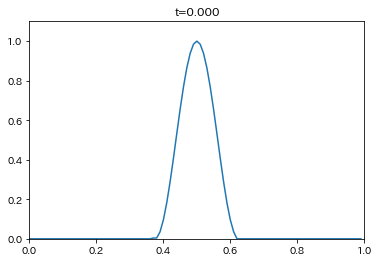

In [13]:
fig, ax = plt.subplots()

# 共通設定・初期設定
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.1])
line, = ax.plot([], [])

# 更新の関数
def animate(frame):
    t = t_list[frame]
    rho = u_list[frame]
    ax.set_title(f"t={t:.3f}")
    line.set_data(x_list, rho)
    return (line)

ani = animation.FuncAnimation(fig, animate, frames=len(t_list), interval=50)
ani.save("./wave_1d.gif", writer="pillow", dpi=300)

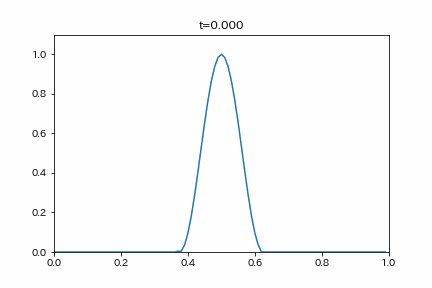

In [15]:
from IPython.display import Image

# アニメーション再生
Image("./wave_1d.gif", format='png')